# Cartopy 是一个开源免费的第三方 Python 扩展包，由英国气象办公室的科学家们开发，支持 Python 2.7 和 Python 3，致力于使用最简单直观的方式生成地图，并提供对 matplotlib 友好的协作接口。

## 1.自定义边界形状

In [1]:
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature   #  载入所需要的包

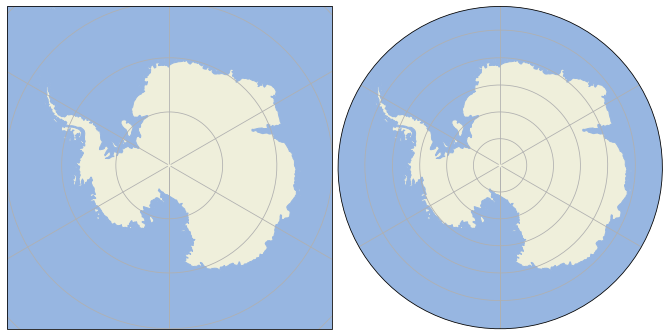

In [2]:
fig = plt.figure(figsize=[10, 5])
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())  #生成1*2子图
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.SouthPolarStereo(),
                    sharex=ax1, sharey=ax1)
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)

# 将地图限制为纬度为-60度及以下。
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())  #规定图片范围
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.OCEAN)

ax1.gridlines()   # 添加网格
ax2.gridlines()

ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.OCEAN)

#在第二图的轴坐标中计算一个圆将其用作地图的边界。随意平移/缩放，边界将永久保持圆形。
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax2.set_boundary(circle, transform=ax2.transAxes)

plt.show()

## 2.地图瓦块的获取

### 展示了Cartopy绘制地图瓦块的能力，这些地图图块可从Stamen图块服务器按需下载。在内部将这些瓦块组合成单个图像，并显示在Cartopy GeoAxes中。。 

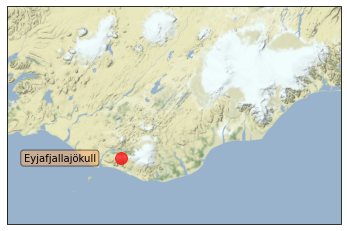

In [6]:
from matplotlib.transforms import offset_copy
import cartopy.io.img_tiles as cimgt

 # 创建一个Stamen地形背景实例。与ccrs.platecarree投影不同
stamen_terrain = cimgt.Stamen('terrain-background')

fig = plt.figure()

# 在图块的投影中创建一个GeoAxes。
ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)

#将地图的范围限制在较小的经度/纬度范围内。
ax.set_extent([-22, -15, 63, 65], crs=ccrs.Geodetic())

# 在缩放级别8上添加Stamen地形数据。
ax.add_image(stamen_terrain, 8)

# 为Eyjafjallajökull火山添加标记。
ax.plot(-19.613333, 63.62, marker='o', color='red', markersize=12,
        alpha=0.7, transform=ccrs.Geodetic())

#使用cartopy接口为大地坐标系创建一个matplotlib变换对象。 
#我们将其与matplotlib的offset_copy函数一起使用，
#以定义一个坐标系统，该系统将文本向左平移25个像素。
geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
text_transform = offset_copy(geodetic_transform, units='dots', x=-25)

#在火山左侧添加25个像素的文本。
ax.text(-19.613333, 63.62, u'Eyjafjallajökull',
        verticalalignment='center', horizontalalignment='right',
        transform=text_transform,
        bbox=dict(facecolor='sandybrown', alpha=0.5, boxstyle='round'))
plt.show()

## 3.风场 ax.quiver

In [7]:
def sample_data(shape=(20, 30)):
    """
    返回数学计算出的某些矢量数据的``（x，y，u，v，crs）''。 
    返回的CRS将是北极立体投影
    这意味着矢量在PlateCarree投影中的间距将不均匀。

    """
    crs = ccrs.NorthPolarStereo()
    scale = 1e7
    x = np.linspace(-scale, scale, shape[1])
    y = np.linspace(-scale, scale, shape[0])

    x2d, y2d = np.meshgrid(x, y)
    u = 10 * np.cos(2 * x2d / scale + 3 * y2d / scale)
    v = 20 * np.cos(6 * x2d / scale)

    return x, y, u, v, crs

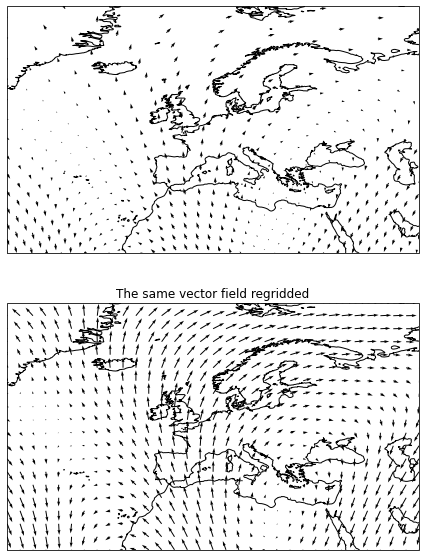

In [8]:
fig = plt.figure(figsize=(8, 10))

x, y, u, v, vector_crs = sample_data(shape=(50, 50))
ax1 = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax1.coastlines('50m')
ax1.set_extent([-45, 55, 20, 80], ccrs.PlateCarree())
ax1.quiver(x, y, u, v, transform=vector_crs)

ax2 = fig.add_subplot(2, 1, 2, projection=ccrs.PlateCarree())
ax2.set_title('The same vector field regridded')
ax2.coastlines('50m')
ax2.set_extent([-45, 55, 20, 80], ccrs.PlateCarree())

ax2.quiver(x, y, u, v, transform=vector_crs, regrid_shape=20) #这个函数绘画矢量数据

plt.show()

## 4.地形图 

<ipython-input-9-00293b5d3749>:48: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(cf, shrink=0.7, orientation='vertical',


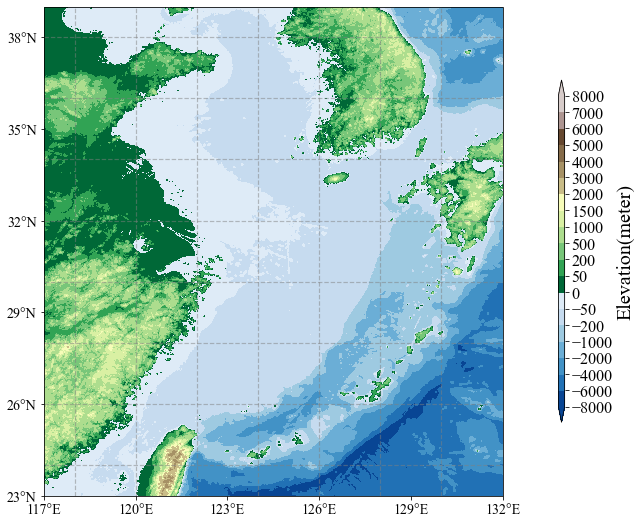

In [9]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib import rcParams
from cartopy.io import shapereader as shpreader
 
config = {"font.family": 'Times New Roman',
          "font.size": 14, "mathtext.fontset": 'stix'}
rcParams.update(config)
 
# 读取全球地形数据,可以再GEBCO的官网上找
ds = xr.open_dataset(r'C:\Users\Administrator\Downloads\GEBCO_26_Feb_2023_51b17a8615ba\gebco_2022_n39.0_s23.0_w117.0_e132.5.nc')
# print(ds)
# 准备用于绘图的数据
lon =ds.lon[:]  
lat = ds.lat[:] 
dem = ds['elevation'].data
 
# 构建经纬网格
lon, lat = np.meshgrid(lon, lat)
 
# 设置地图全局属性
fig = plt.figure(1, figsize=[20,9])
proj = ccrs.PlateCarree()
ax = plt.subplot(1, 1, 1, projection=proj)
extent = [117, 132, 23, 39] #改变大小可以得到不同区域
ax.set_extent(extent, crs=proj)
 
# china = shpreader.Reader(r"D:bou2_4l.dbf").geometries()
# 绘制中国国界省界九段线等等
 
# 创建底图，设置地图投影为World Plate Carrée，分辨率为高分辨率，地图范围为全球 20个
levels = [-8000, -6000, -4000, -2000, -1000, -200, -50, 0, 50,
          200, 500, 1000, 1500, 2000, 3000, 4000, 5000, 6000, 7000, 8000]
# levels=np.arange(-8000,8000,1000)
 
# 创建分级
color = ['#084594', '#2171b5', '#4292c6', '#6baed6', '#9ecae1', '#c6dbef', '#deebf7', '#006837',
         '#31a354', '#78c679', '#addd8e', '#d9f0a3', '#f7fcb9', '#c9bc87', '#a69165', '#856b49',
         '#664830', '#ad9591', '#d7ccca']  # 设置色带，19个颜色
cf = ax.contourf(lon, lat, dem, levels=levels, colors=color, extend='both')
 
# ax.add_geometries(china, ccrs.PlateCarree(),
#                   facecolor='none', edgecolor='black', zorder=1)  # , linewidth=12)  # , zorder=1)
# 设置图例,shrink调整色标长度
cb = plt.colorbar(cf, shrink=0.7, orientation='vertical',
                  pad=0.05, aspect=50, ticks=levels,extend = 'both')
cb.set_ticks(levels)  # 设置色带刻度
cb.ax.tick_params(labelsize=16)
cb.set_label('Elevation(meter)', fontsize=20)  # 设置图例名称和字体大小
ax.set_xticks(np.arange(extent[0], extent[1]+1, 3), crs=proj)
ax.set_yticks(np.arange(extent[-2], extent[-1]+1, 3), crs=proj)
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=False))
ax.yaxis.set_major_formatter(LatitudeFormatter())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1.2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False   #关闭顶端标签
gl.right_labels = False #关闭右侧标签
ax.spines['bottom'].set_linewidth('5')
ax.spines['top'].set_linewidth('5')
ax.spines['left'].set_linewidth('5')
ax.spines['right'].set_linewidth('5')
# plt.savefig(r'H:\thesis\pic\示意图_2_original.jpg', dpi=300,bbox_inches='tight', pad_inches=0)
plt.show()


## 5.水色要素

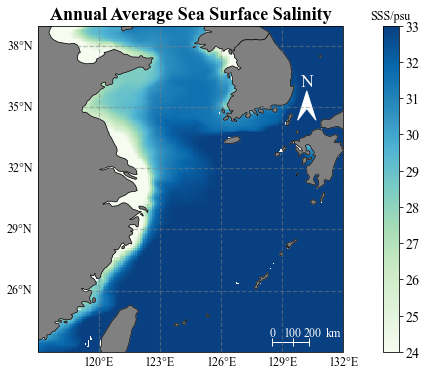

In [16]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER, mticker
import cartopy.feature as cfeat
import matplotlib.patches as mpatches
def add_scalebar(ax,lon0,lat0,length,size=0.45):
    '''
    ax: 坐标轴
    lon0: 经度
    lat0: 纬度
    length: 长度
    size: 控制粗细和距离的
    '''
    # style 3
    ax.hlines(y=lat0,  xmin = lon0, xmax = lon0+length/111, colors="white", ls="-", lw=1, label='%d km' % (length))
    ax.vlines(x = lon0, ymin = lat0-size, ymax = lat0+size, colors="white", ls="-", lw=1)
    ax.vlines(x = lon0+length/2/100, ymin = lat0-size, ymax = lat0+size, colors="white", ls="-", lw=1)
    ax.vlines(x = lon0+length/111, ymin = lat0-size, ymax = lat0+size, colors="white", ls="-", lw=1)
    ax.text(lon0+length/100,lat0+size+0.05,'%d' % (length),horizontalalignment = 'center',color="white",fontsize=12)
    ax.text(lon0+length/2/100,lat0+size+0.05,'%d' % (length/2),horizontalalignment = 'center',color="white",fontsize=12)
    ax.text(lon0,lat0+size+0.05,'0',horizontalalignment = 'center',color="white",fontsize=12)
    ax.text(lon0+length/100/2*3,lat0+size+0.05,'km',horizontalalignment = 'center',color="white",fontsize=12)
    
    
def add_north(ax, labelsize=18, loc_x=0.88, loc_y=0.85, width=0.06, height=0.09, pad=0.14):
    """
    画一个比例尺带'N'文字注释
    主要参数如下
    :param ax: 要画的坐标区域 Axes实例 plt.gca()获取即可
    :param labelsize: 显示'N'文字的大小
    :param loc_x: 以文字下部为中心的占整个ax横向比例
    :param loc_y: 以文字下部为中心的占整个ax纵向比例
    :param width: 指南针占ax比例宽度
    :param height: 指南针占ax比例高度
    :param pad: 文字符号占ax比例间隙
    :return: None
    """
    minx, maxx = ax.get_xlim()
    miny, maxy = ax.get_ylim()
    ylen = maxy - miny
    xlen = maxx - minx
    left = [minx + xlen*(loc_x - width*.5), miny + ylen*(loc_y - pad)]
    right = [minx + xlen*(loc_x + width*.5), miny + ylen*(loc_y - pad)]
    top = [minx + xlen*loc_x, miny + ylen*(loc_y - pad + height)]
    center = [minx + xlen*loc_x, left[1] + (top[1] - left[1])*.4]
    triangle = mpatches.Polygon([left, top, right, center], color='white')
    ax.text(s='N',
            x=minx + xlen*loc_x,
            y=miny + ylen*(loc_y - pad + height),
            fontsize=labelsize,
            horizontalalignment='center',
            verticalalignment='bottom',color = 'white')
    ax.add_patch(triangle)
    
def add_text(ax,length):
    ax.text(118,37,'(%s)' % (length),horizontalalignment = 'center',color="white",fontsize=18,weight = 'bold')
    
    
path=r'C:\Users\Administrator\Downloads\cmems_mod_glo_phy_my_0.083_P1M-m_1677148753896.nc'
SSS=xr.open_dataset(path)
# sst2= sst1.sel(time = SSS.time[0])

lat=SSS.latitude[:]
lon=SSS.longitude[:]
lon_range = lon[(lon>=121)&(lon <=125)]

lat_range = lat[(lat >=27)& (lat<=34)]
# sst1 = SSS.so.sel(latitude = lat_range,longitude = lon_range).mean(axis= (0,1))
sst1 = SSS.so.mean(axis= (0,1))
# print(sst1.shape)
# print(sst1.shape)
fig=plt.figure(figsize=(14,6))#设置画布
plt.rcParams['font.sans-serif'] = ['Kaiti']
plt.rcParams['axes.unicode_minus'] = False 
lon_formatter=LONGITUDE_FORMATTER
lat_formatter=LATITUDE_FORMATTER
fig_ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
fig_ax1.add_feature(cfeat.OCEAN, zorder=0,color = 'white',edgecolor='black')
fig_ax1.add_feature(cfeat.LAND,  color = 'grey',zorder=1,edgecolor='black') 
fig_ax1.add_feature(cfeat.BORDERS.with_scale('50m'), linewidth=0.8, zorder=1)
fig_ax1.add_feature(cfeat.COASTLINE.with_scale('50m'), linewidth=0.6, zorder=1) 
fig_ax1.set_extent([117, 132.00001,23, 39.0001],crs = ccrs.PlateCarree())
gl = fig_ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1.2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False   #关闭顶端标签
gl.right_labels = False #关闭右侧标签
gl.xlocator = mticker.FixedLocator([117,120,123,126,129,132])
gl.xformatter = LONGITUDE_FORMATTER#x轴设为经度格式
gl.xlabel_style = {'size':12, 'color': 'k','rotation':0}
gl.yformatter = LATITUDE_FORMATTER#y轴设为纬度格式
gl.ylocator = mticker.FixedLocator([23,26,29,32,35,38])
gl.ylabel_style = {'size':12,'rotation':0}
add_north(fig_ax1) 
add_scalebar(fig_ax1,128.5,23.5,200,size=0.2)
# im = sst1.plot(ax=fig_ax1,cmap='GnBu',vmax=31,add_colorbar = False)
im = sst1.plot(ax=fig_ax1,cmap='GnBu',vmin = 24,vmax = 33, add_colorbar = False)
cb = plt.colorbar(im)
fig_ax1.set_title('Annual Average Sea Surface Salinity',fontsize = 18,weight = 'bold')
cb.ax.set_title(r'SSS/psu',fontsize=12,weight = 'normal')  
# plt.savefig(r'H:\thesis\pic\Mon_sss\Average_35.jpg',dpi = 300)
plt.show()